In [6]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def convert_multiple_annotations_to_matrices(samples):
    """
    Chuyển danh sách các sample JSON thành ma trận đếm cho từng modality.

    Args:
        samples (list): Danh sách JSON mỗi sample

    Returns:
        tuple: (matrix_text, matrix_image, matrix_multi)
    """
    matrix_text = []
    matrix_image = []
    matrix_multi = []

    for sample in samples:
        # Đếm số nhãn cho từng modality
        counts = {
            "text_modality": [0, 0],
            "image_modality": [0, 0],
            "multi_modality": [0, 0]
        }

        for annot in sample['annotations']:
            for result in annot['result']:
                modality = result['from_name']
                label = result['value']['choices'][0]
                if label == "Non-sarcasm":
                    counts[modality][0] += 1
                elif label == "Sarcasm":
                    counts[modality][1] += 1
                else:
                    raise ValueError(f"Unknown label: {label}")

        matrix_text.append(counts["text_modality"])
        matrix_image.append(counts["image_modality"])
        matrix_multi.append(counts["multi_modality"])

    return matrix_text, matrix_image, matrix_multi

def fleiss_kappa(matrix):
    """
    Tính Fleiss' Kappa cho ma trận đánh giá (n_samples x n_classes).

    Args:
        matrix (list of lists): ma trận đếm số annotator chọn mỗi class

    Returns:
        float: Giá trị Fleiss' Kappa.
    """
    matrix = np.array(matrix)  # 🔧 Convert list -> numpy array
    N, k = matrix.shape        # Số mẫu, số lớp
    n_annotators = 3

    # Tính tần suất mỗi nhãn trên toàn tập
    p_j = np.sum(matrix, axis=0) / (N * n_annotators)

    # Tính xác suất đồng thuận trên mỗi sample
    P_i = (np.sum(matrix**2, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))

    P_bar = np.mean(P_i)
    P_e = np.sum(p_j**2)

    kappa = (P_bar - P_e) / (1 - P_e)
    return kappa


In [8]:
file_path = r'D:\Git_repo\ViSoMMSD\data\interim\round_2\export\round_2_conflict.json'
with open(file_path, 'r', encoding= 'utf-8') as f:
  data = json.load(f)

text, image, multi = convert_multiple_annotations_to_matrices(data)

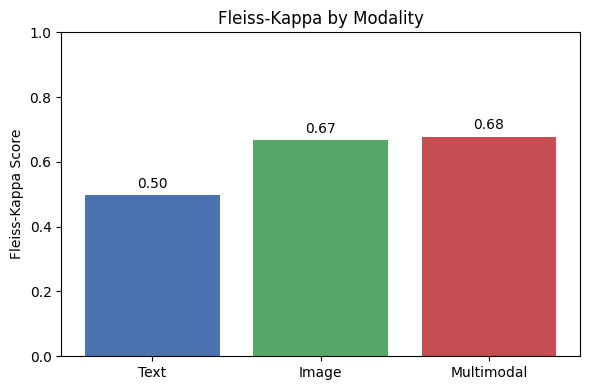

In [9]:
# Tính kappa cho từng modality
kappa_text = fleiss_kappa(text)
kappa_image = fleiss_kappa(image)
kappa_multi = fleiss_kappa(multi)

# Gán nhãn và giá trị
modalities = ["Text", "Image", "Multimodal"]
kappas = [kappa_text, kappa_image, kappa_multi]

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(modalities, kappas, color=["#4c72b0", "#55a868", "#c44e52"])
ax.set_ylim(0, 1)
ax.set_ylabel("Fleiss-Kappa Score")
ax.set_title("Fleiss-Kappa by Modality")

# Hiển thị giá trị trên đỉnh cột
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # khoảng cách từ đỉnh cột
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()
